<a href="https://colab.research.google.com/github/vipulSharma18/Automatic-Emotion-Recognition-on-DEAP-Dataset/blob/main/models/1DCNN_without_Windowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Drive Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Relevant Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Softmax

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report

## GPU Check

In [ ]:
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [ ]:
tf.version.VERSION

'2.4.1'

## Data Preparation

In [ ]:
def convert_transpose(subject_data):
    dataset = []
    for i in range(subject_data.shape[0]):
        dataset.append(subject_data[i].T)
    dataset = np.array(dataset)
    return dataset

#### Extracting the files from .dat files

In [ ]:
import pickle
all_sub_data = []
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = "/content/drive/MyDrive/major project/data_preprocessed_python/s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_eeg = sub_data[:, :32, :128*60]
    dataset = convert_transpose(sub_eeg)
    all_sub_data.extend(dataset)
all_sub_data = np.array(all_sub_data)

In [ ]:
all_sub_data.shape

(1280, 7680, 32)

In [ ]:
for instance in range(all_sub_data.shape[0]):
  all_sub_data[instance] = StandardScaler().fit_transform(all_sub_data[instance])

In [ ]:
all_sub_data.shape

(1280, 7680, 32)

#### Splitting data into train, validation and test sets

In [ ]:
dataset = all_sub_data

In [ ]:
X_train = dataset[:1024, :, : ]
X_val = dataset[1024:1152, : , : ]
X_test = dataset[1152:, : , : ]

#### Generating Labels for the data

In [ ]:
labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
sub_labels = labels["Valence-Arousal Model Quadrant"].astype('int')
sub_labels

0       3
1       3
2       3
3       1
4       2
       ..
1275    1
1276    1
1277    1
1278    1
1279    2
Name: Valence-Arousal Model Quadrant, Length: 1280, dtype: int64

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
sub_labels = lb.fit_transform(sub_labels)
print(lb.classes_)
print(sub_labels.shape)
print(sub_labels)

[0 1 2 3]
(1280, 4)
[[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]]


In [ ]:
y_train = sub_labels[:1024]
y_val = sub_labels[1024:1152]
y_test = sub_labels[1152:]

#### Converting numpy arrays to tf.data.Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset= tf.data.Dataset.from_tensor_slices((X_test, y_test))

#### Batching and Shuffling of data

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 50

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Evaluation Plot and confusion matrix functions

In [ ]:
def plot_evaluation_curves(history, EPOCHS):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def test_metrics(model):
  test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
  print("The testing accuracy is:", test_acc)
  y_pred = model.predict(X_test, batch_size=64, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_true = np.argmax(y_test, axis = 1)
  print(classification_report(y_true, y_pred_bool, zero_division = 0, digits = 4))

## Model Building, Simple 1D CNN with 23 layers with no windowing of Signals

In [ ]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=23,  activation='relu',strides = 3, input_shape=(7680, 32)))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling1D(pool_size=2, strides = 2))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=13, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32,kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2))
model.add(Dropout(rate = 0.2))
model.add(Conv1D(filters=128, kernel_size=11, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(Conv1D(filters=48, kernel_size=15, activation='relu'))
model.add(Dropout(rate = 0.1))
model.add(MaxPooling1D(pool_size=2, strides = 2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer='l1'))
model.add(Dense(4, activation = 'softmax', kernel_regularizer='l1'))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.00001) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= 'accuracy')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 2553, 8)           5896      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2553, 8)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1276, 8)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1276, 8)           32        
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1264, 64)          6720      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 632, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 630, 128)         

In [ ]:
plot_model(model, to_file='plain 1dcnn.png', show_shapes = True)

In [ ]:
EPOCHS = 150
history = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data= val_dataset)

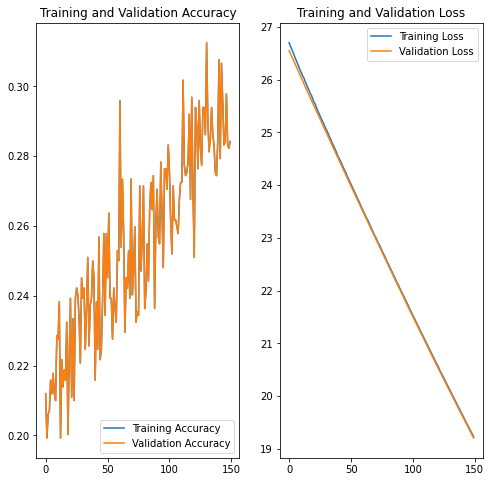

In [ ]:
plot_evaluation_curves(history, EPOCHS)

In [ ]:
test_metrics(model)

1/1 - 0s - loss: 19.2054 - accuracy: 0.3203
The testing accuracy is: 0.3203125
2/2 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0     0.2000    0.0588    0.0909        17
           1     0.0000    0.0000    0.0000        34
           2     0.3721    0.4444    0.4051        36
           3     0.3077    0.5854    0.4034        41

    accuracy                         0.3203       128
   macro avg     0.2199    0.2722    0.2248       128
weighted avg     0.2298    0.3203    0.2552       128



## Model Simple 1D CNN with 2 Layers

In [ ]:
Simplemodel = Sequential()
Simplemodel.add(Conv1D(filters=32, kernel_size=5,strides = 3, input_shape=(7680, 32)))
Simplemodel.add(BatchNormalization())
Simplemodel.add(tf.keras.layers.Activation('relu'))
Simplemodel.add(MaxPooling1D(pool_size=2, strides = 2))
Simplemodel.add(Conv1D(filters=32, kernel_size=5,strides = 3, input_shape=(7680, 32)))
Simplemodel.add(BatchNormalization())
Simplemodel.add(tf.keras.layers.Activation('relu'))
Simplemodel.add(MaxPooling1D(pool_size=2, strides = 2))
Simplemodel.add(Flatten())
Simplemodel.add(Dense(15, activation='relu', kernel_regularizer='l1'))
Simplemodel.add(Dropout(rate = 0.5))
Simplemodel.add(Dense(4, activation = 'softmax', kernel_regularizer='l1'))
Simplemodel.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-08) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= 'accuracy')

In [ ]:
Simplemodel.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 2559, 32)          5152      
_________________________________________________________________
batch_normalization_16 (Batc (None, 2559, 32)          128       
_________________________________________________________________
activation_11 (Activation)   (None, 2559, 32)          0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1279, 32)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 425, 32)           5152      
_________________________________________________________________
batch_normalization_17 (Batc (None, 425, 32)           128       
_________________________________________________________________
activation_12 (Activation)   (None, 425, 32)          

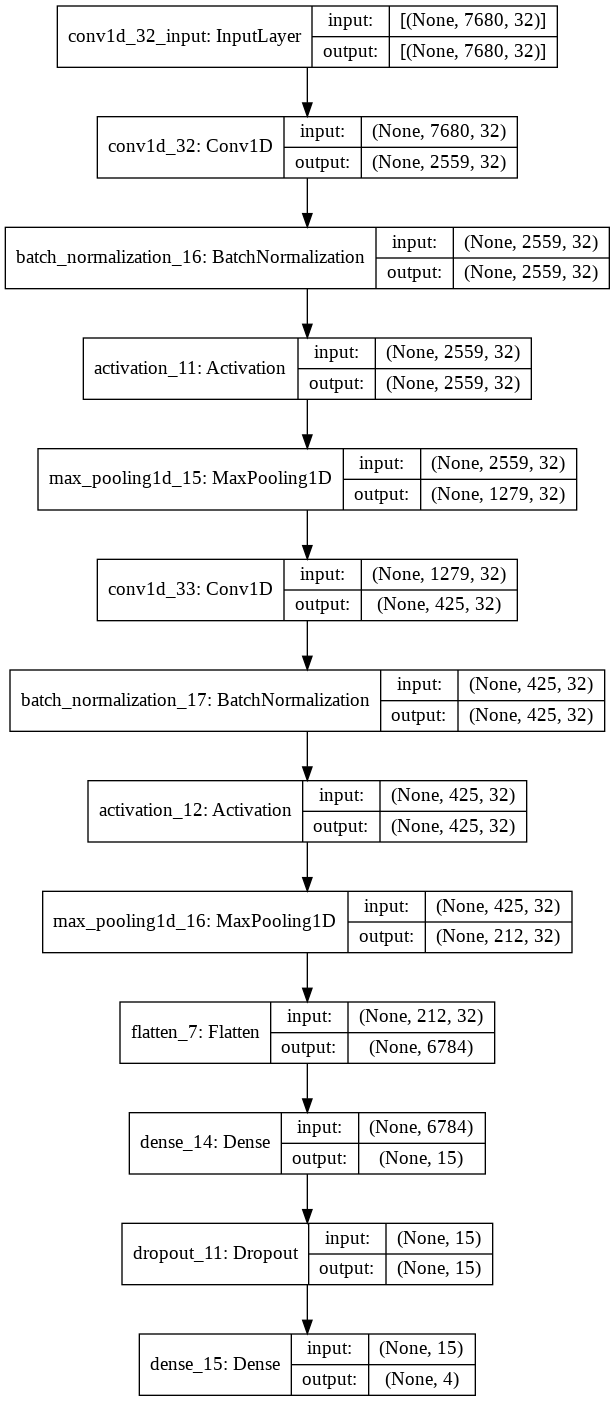

In [ ]:
plot_model(Simplemodel, to_file='12 layered 1dcnn.png', show_shapes = True)

In [ ]:
EPOCHS = 200
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]
history = Simplemodel.fit(train_dataset, epochs = EPOCHS, validation_data= val_dataset, callbacks=callbacks)

Epoch 1/200
8/8 [==============================] - 4s 341ms/step - loss: 16.7424 - accuracy: 0.2554 - val_loss: 16.2490 - val_accuracy: 0.2578
Epoch 2/200
8/8 [==============================] - 2s 288ms/step - loss: 16.1957 - accuracy: 0.2889 - val_loss: 15.8355 - val_accuracy: 0.2656
Epoch 3/200
8/8 [==============================] - 2s 293ms/step - loss: 15.7115 - accuracy: 0.3424 - val_loss: 15.3445 - val_accuracy: 0.3125
Epoch 4/200
8/8 [==============================] - 2s 286ms/step - loss: 15.1961 - accuracy: 0.3350 - val_loss: 14.8347 - val_accuracy: 0.3359
Epoch 5/200
8/8 [==============================] - 2s 289ms/step - loss: 14.6764 - accuracy: 0.3282 - val_loss: 14.3156 - val_accuracy: 0.3281
Epoch 6/200
8/8 [==============================] - 2s 286ms/step - loss: 14.1663 - accuracy: 0.2993 - val_loss: 13.7949 - val_accuracy: 0.3047
Epoch 7/200
8/8 [==============================] - 2s 297ms/step - loss: 13.6234 - accuracy: 0.3329 - val_loss: 13.2795 - val_accuracy: 0.3125

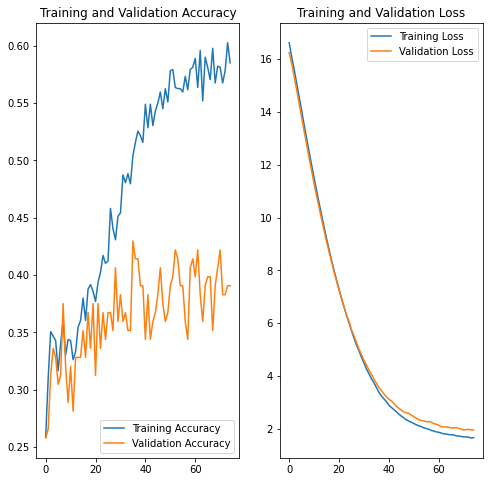

In [ ]:
plot_evaluation_curves(history, 75)

In [ ]:
test_metrics(Simplemodel)

1/1 - 0s - loss: 2.0481 - accuracy: 0.3047
The testing accuracy is: 0.3046875
2/2 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        17
           1     0.2903    0.2647    0.2769        34
           2     0.0000    0.0000    0.0000        36
           3     0.3093    0.7317    0.4348        41

    accuracy                         0.3047       128
   macro avg     0.1499    0.2491    0.1779       128
weighted avg     0.1762    0.3047    0.2128       128



## Pyramidal Lightweight 1D CNN

In [ ]:
LP1DCNN = Sequential()
LP1DCNN.add(Conv1D(filters=32, kernel_size=5,strides = 3, input_shape=(7680, 32)))
LP1DCNN.add(BatchNormalization())
LP1DCNN.add(tf.keras.layers.Activation('relu'))
LP1DCNN.add(Conv1D(filters=24, kernel_size=3,strides = 2))
LP1DCNN.add(BatchNormalization())
LP1DCNN.add(tf.keras.layers.Activation('relu'))
LP1DCNN.add(Conv1D(filters=16, kernel_size=3,strides = 2))
LP1DCNN.add(BatchNormalization())
LP1DCNN.add(tf.keras.layers.Activation('relu'))
LP1DCNN.add(Conv1D(filters=8, kernel_size=5,strides = 3))
LP1DCNN.add(BatchNormalization())
LP1DCNN.add(tf.keras.layers.Activation('relu'))
LP1DCNN.add(Flatten())
LP1DCNN.add(Dense(20, activation='relu'))
LP1DCNN.add(Dropout(rate = 0.5))
LP1DCNN.add(Dense(4, activation = 'softmax'))
LP1DCNN.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-08) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= 'accuracy')

In [ ]:
LP1DCNN.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 2559, 32)          5152      
_________________________________________________________________
batch_normalization_26 (Batc (None, 2559, 32)          128       
_________________________________________________________________
activation_21 (Activation)   (None, 2559, 32)          0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 1279, 24)          2328      
_________________________________________________________________
batch_normalization_27 (Batc (None, 1279, 24)          96        
_________________________________________________________________
activation_22 (Activation)   (None, 1279, 24)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 639, 16)         

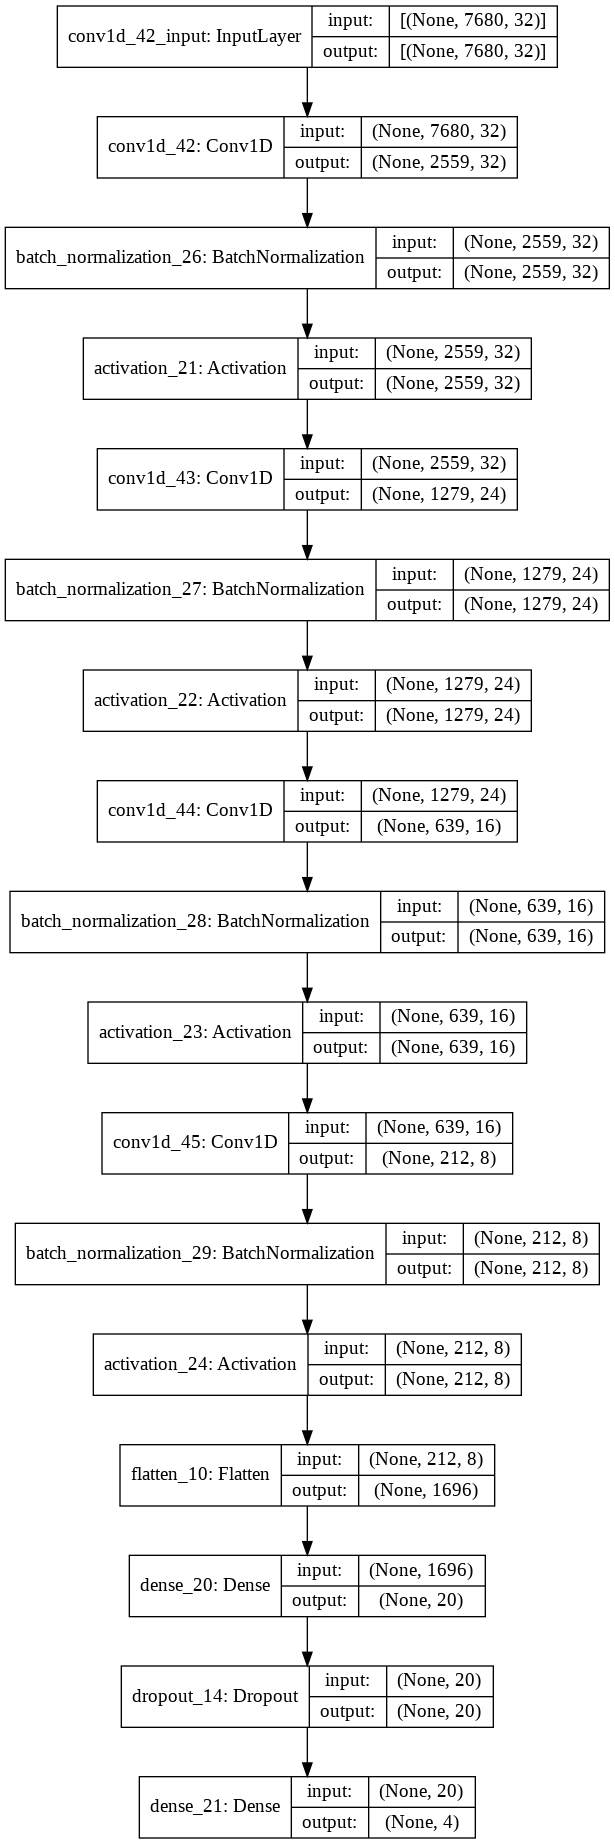

In [ ]:
plot_model(LP1DCNN, to_file='LP1dcnn.png', show_shapes = True)

In [ ]:
EPOCHS = 200
history = LP1DCNN.fit(train_dataset, epochs = EPOCHS, validation_data= val_dataset)

Epoch 1/200
8/8 [==============================] - 3s 296ms/step - loss: 1.3529 - accuracy: 0.3613 - val_loss: 1.3666 - val_accuracy: 0.2891
Epoch 2/200
8/8 [==============================] - 2s 298ms/step - loss: 1.3579 - accuracy: 0.3496 - val_loss: 1.3645 - val_accuracy: 0.2891
Epoch 3/200
8/8 [==============================] - 2s 295ms/step - loss: 1.3357 - accuracy: 0.3730 - val_loss: 1.3633 - val_accuracy: 0.2891
Epoch 4/200
8/8 [==============================] - 2s 296ms/step - loss: 1.3272 - accuracy: 0.3789 - val_loss: 1.3627 - val_accuracy: 0.3047
Epoch 5/200
8/8 [==============================] - 2s 296ms/step - loss: 1.3171 - accuracy: 0.3848 - val_loss: 1.3609 - val_accuracy: 0.3281
Epoch 6/200
8/8 [==============================] - 2s 297ms/step - loss: 1.3109 - accuracy: 0.3955 - val_loss: 1.3594 - val_accuracy: 0.3281
Epoch 7/200
8/8 [==============================] - 2s 297ms/step - loss: 1.3081 - accuracy: 0.3779 - val_loss: 1.3575 - val_accuracy: 0.3359
Epoch 8/200
8

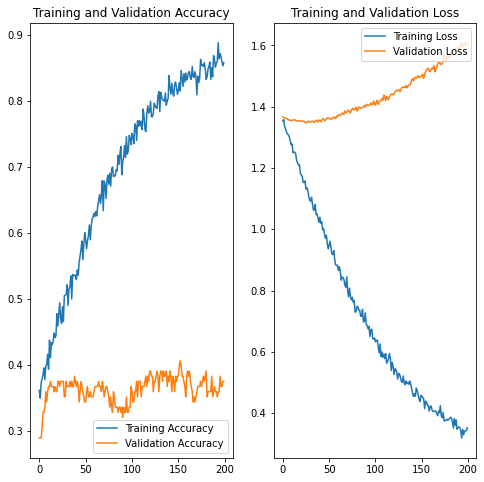

In [ ]:
plot_evaluation_curves(history, EPOCHS)

In [ ]:
test_metrics(LP1DCNN)

1/1 - 0s - loss: 1.8355 - accuracy: 0.2812
The testing accuracy is: 0.28125
2/2 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0     0.1500    0.1765    0.1622        17
           1     0.3636    0.2353    0.2857        34
           2     0.2857    0.1667    0.2105        36
           3     0.2923    0.4634    0.3585        41

    accuracy                         0.2812       128
   macro avg     0.2729    0.2605    0.2542       128
weighted avg     0.2905    0.2812    0.2715       128



# Tensorboard Integration

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs

%rm -rf ./logs/

In [ ]:
from tensorboard.plugins.hparams import api as hp


In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([10, 16]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))

METRIC_ACCURACY = 'accuracy'
import time

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
with tf.summary.create_file_writer('logs/hparam_tuning'+str(current_time)).as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
  model = Sequential()
  model.add(Conv1D(filters=8, kernel_size=23,  activation='relu',strides = 3, input_shape=(7680, 32)))
  model.add(MaxPooling1D(pool_size=2, strides = 2))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Conv1D(filters=64, kernel_size=13, activation='relu'))
  model.add(MaxPooling1D(pool_size=2, strides = 2))
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=32,kernel_size=7, activation='relu'))
  model.add(MaxPooling1D(pool_size=2, strides = 2))
  model.add(Dropout(0.3))
  model.add(Conv1D(filters=128, kernel_size=11, activation='relu'))
  model.add(MaxPooling1D(pool_size=2, strides = 2))
  model.add(Dropout(0.3))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2, strides = 2))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(16, activation='relu', kernel_regularizer='l1'))
  model.add(Dense(4, activation = 'softmax', kernel_regularizer='l1'))
  model.compile(optimizer= "RMSprop", loss = tf.keras.losses.CategoricalCrossentropy(), metrics= 'accuracy')
  model.fit(train_dataset, batch_size = BATCH_SIZE, validation_data= val_dataset, epochs=25)
  _, accuracy = model.evaluate(test_dataset)
  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    hparams = {
        HP_NUM_UNITS: num_units,
        HP_DROPOUT: dropout_rate,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning'+ str(current_time) +'/' + run_name, hparams)
    session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning22\:21\:57
